<a href="https://colab.research.google.com/github/s-thandri/labelflipping/blob/main/german_credit_lr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [1]:
#Imports some of the libraries that we will be using
import pandas as pd
import numpy as np
import math
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


#Parity and Model Building Functions

In [ ]:
#This function is being used to calculate the statistical parity of the data set
#test_data: The original data frame containing the test data
#predictors: List of the all the column names AKA IV's
#prediction_df: Contains the predicitons made by the DT model
#sensitive_attr: Name of the sensitive attr
#sensitive_attr_cutoff: Cut off value for sensitive attr
#concat_col: Name of column I am creating new dataframe on
def s_parity(test_data, predictors, prediction_df, sensitive_attr, sensitive_attr_cutoff, concat_col):
    #Creating a new DF that contains all the datapoints from the test data and the predictions made from LR model
    #Concat_col: credit_risk_12
    test_demo_df = pd.DataFrame(test_data, columns = predictors)
    predicted_df = pd.DataFrame(prediction_df, columns = [concat_col])
    concat_df = pd.concat([test_demo_df,predicted_df], axis=1)

    #Get the two groups of people totals
    total_unpriv = (len(concat_df[concat_df[sensitive_attr]<sensitive_attr_cutoff]))
    total_priv = (len(concat_df[concat_df[sensitive_attr]>=sensitive_attr_cutoff]))

    #Number of people accepted
    total_credit_unpriv = len(concat_df[(concat_df[concat_col] == 1) & (concat_df[sensitive_attr] < sensitive_attr_cutoff)])
    total_credit_priv = len(concat_df[(concat_df[concat_col] == 1) & (concat_df[sensitive_attr] >= sensitive_attr_cutoff)])

    #Percentage of approved people
    p_unpriv = total_credit_unpriv/total_unpriv
    p_priv = total_credit_priv/total_priv


    #Calculate the parity
    parity = p_priv - p_unpriv


    return parity

In [ ]:
#Make changes to make more efficient
#Function used to run the DT model
#train_dataset: Training dataset to train the model
#independent_var: Column names
#dependent_var: Prediction column name
#concat_col: Name of column creating new DF on
def decision_tree(train_dataset, independent_var, dependent_var, concat_col):
        #Split the data up into train and test values and then run the DT model
        #These steps aren't neccessary to consistenly do over and over again
        x = train_dataset[independent_var].values
        y = train_dataset[dependent_var].values
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=310)
        clf = LogisticRegression(criterion = 'entropy',max_depth = 3, min_samples_leaf=5)
        log = clf.fit(x_train,y_train)
        prediction = log.predict(x_test)

        #Printing the Overall accuracy of the model after one run
        #F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
        #file.write(f'\nAccuracy of the model on Testing Sample Data: {F1_Score}')

        #Prints out the average across all ten run throughs
        #Accuracy_Values=cross_val_score(log, x , y, cv=10, scoring='f1_weighted')

        accuracy = accuracy_score(y_test,prediction)*100

        #After running the model I return a df with the datapoints and the labels
        test_demo_df = pd.DataFrame(x_test, columns = independent_var)
        #Concat_col: credit_risk_12
        predicted_df = pd.DataFrame(prediction, columns = [concat_col])

        return accuracy, test_demo_df, predicted_df

#Building Original Decision Tree Model

In [ ]:
#Defining the columns and creating the Dataframe with all 1000 datapoints
columns = ["checking_account_status", "duration", "credit_history", "purpose", "credit_amount", "savings_account_status", "employment_status", "installment_rate", "personal_status", "other_debtors", "residence_since", "property", "age", "other_installment_plans", "housing", "existing_credits", "job", "num_dependents", "telephone", "foreign_worker", "credit_risk"]
german_df = pd.read_table('german.data', header = None, delim_whitespace=True, names = columns)

In [ ]:
#Encode all the non-numeric columns with dummies
encoded_data=pd.get_dummies(german_df,columns=['checking_account_status','credit_history','savings_account_status','employment_status','personal_status','other_debtors','property','other_installment_plans','housing','job','telephone','foreign_worker','purpose'], drop_first=True)

In [ ]:
encoded_data

,duration,credit_amount,installment_rate,residence_since,age,existing_credits,num_dependents,credit_risk,checking_account_status_A12,checking_account_status_A13,...,foreign_worker_A202,purpose_A41,purpose_A410,purpose_A42,purpose_A43,purpose_A44,purpose_A45,purpose_A46,purpose_A48,purpose_A49
0,6,1169,4,4,67,2,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,48,5951,2,2,22,1,1,2,1,0,...,0,0,0,0,1,0,0,0,0,0
2,12,2096,2,3,49,1,2,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,42,7882,2,4,45,1,2,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,24,4870,3,4,53,2,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,3,4,31,1,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
996,30,3857,4,4,40,1,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
997,12,804,4,4,38,1,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
998,45,1845,4,4,23,1,1,2,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
#Initialize all the different columns including predictors and target variable
encoded_data.columns
target_var = 'credit_risk'
predictors = ['duration', 'credit_amount', 'installment_rate',
       'residence_since', 'age', 'existing_credits', 'num_dependents',
       'checking_account_status_A12',
       'checking_account_status_A13', 'checking_account_status_A14',
       'credit_history_A31', 'credit_history_A32', 'credit_history_A33',
       'credit_history_A34', 'savings_account_status_A62',
       'savings_account_status_A63', 'savings_account_status_A64',
       'savings_account_status_A65', 'employment_status_A72',
       'employment_status_A73', 'employment_status_A74',
       'employment_status_A75', 'personal_status_A92', 'personal_status_A93',
       'personal_status_A94', 'other_debtors_A102', 'other_debtors_A103',
       'property_A122', 'property_A123', 'property_A124',
       'other_installment_plans_A142', 'other_installment_plans_A143',
       'housing_A152', 'housing_A153', 'job_A172', 'job_A173', 'job_A174',
       'telephone_A192', 'foreign_worker_A202']


In [ ]:
#Setting the columns to each part of the decision tree
#x conatins the IV's
#y contains the DV
x = encoded_data[predictors].values
y = encoded_data[target_var].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=310)
#X-train is all the data points for training
#y_train contains the labels for each of the training data points
#x_test contains all the testing data points
#y_test contains the ground truth for each of the test data points

In [ ]:
#Run the DT classifier
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 20, min_samples_leaf=5)
dt = clf.fit(x_train,y_train)
prediction = dt.predict(x_train)
prediction_prob = dt.predict_proba(x_test)
accuracy = accuracy_score(y_train,prediction)*100
print(accuracy)

87.875


In [ ]:
#Break the test dataframe into different groups
#Unprotected group is everyone <45
#Complement group is everyone >= 45
test_demo_df = pd.DataFrame(x_test, columns = predictors)
predicted_df = pd.DataFrame(prediction, columns = ['credit_risk_12'])
concat_df = pd.concat([test_demo_df,predicted_df], axis=1)

#Get the two groups of people totals
total_unpriv = (len(concat_df[concat_df['age']<45]))
total_priv = (len(concat_df[concat_df['age']>=45]))

#Number of people accepted
total_credit_unpriv = len(concat_df[(concat_df['credit_risk_12'] == 1) & (concat_df['age'] < 45)])
total_credit_priv = len(concat_df[(concat_df['credit_risk_12'] == 1) & (concat_df['age'] >= 45)])

#Percentage of approved people
p_unpriv = total_credit_unpriv/total_unpriv
p_priv = total_credit_priv/total_priv

statistical_parity = p_priv - p_unpriv
print(f'Statistical Parity: {statistical_parity:.5f}')
#decision_tree()

Statistical Parity: 0.03125


#Iterative Flipping

In [ ]:
#Combine x_train and y_train
#I combine these so that when I flip the labels I have one DF that I work with
#Rather than 2 numpy.ndarrays
train_demo_df = pd.DataFrame(x_train, columns = predictors)
train_outcome_df = pd.DataFrame(y_train, columns = ['credit_risk'])
train_full_df = pd.concat([train_demo_df, train_outcome_df], axis=1)

In [ ]:
#When flipping the label make sure convert the flip before into its original value

#Combine x_train and y_train
#Retrain the model after combining them and then flip and calculate
#Implement label flipping and recalculate

#Each list holds a different value

#list_parity holds each parity value after each flip and recalculation
list_parity = []
#list_acc holds the accuracy of each iteration after a flip
list_acc = []
#list_flip holds the row number of the flip; starts at 0 and goes through the whole
list_flip = []

#Iterating through the training dataset
for index, row in train_full_df.iterrows():
  #If the row that I am on has the label 1 (credit_risk is the label name) then I will flip it
  #And then run the decision_tree function to get the accuracy, the DF that contains datapoints,
  #And the DF that contains the predictions
  #The two DF's are then combined in the s_parity function to calculate parity
    if row['credit_risk'] == 1:
      #Flip the label
        train_full_df.at[index, 'credit_risk'] = 2

        #Run the decision tree function
        #train_full_df: training dataset
        #predictors: IV's
        #target_var: DV's
        #'credit_risk12': this is the column that the labels for the test_prediction is in
        accuracy,test_datapoints, test_prediction = decision_tree(train_full_df, predictors, target_var, 'credit_risk_12')

        #list_flip: contains the row number that has just been flipped
        #list_num: contains the accuracy value just calculated
        list_flip.append(index)
        list_acc.append(accuracy)

        ##################################################################################
        #After calculating the accuracy parity calculation is next
        parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')
        #list_parity: contains the parity value after the flip
        print(parity)
        list_parity.append(parity)

        #Flips the label back to its original value
        train_full_df.at[index,'credit_risk'] = 1

    #Repeats all the same steps as above but this time if the original label is 2
    elif row['credit_risk'] == 2:
        train_full_df.at[index, 'credit_risk'] = 1

        accuracy,test_datapoints, test_prediction = decision_tree(train_full_df, predictors, target_var, 'credit_risk_12')
        list_flip.append(index)
        list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')
        print(parity)
        list_parity.append(parity)

        train_full_df.at[index,'credit_risk'] = 2

0.16134598792062116
0.16134598792062116
0.16134598792062116
0.16134598792062116
0.16134598792062116
0.16134598792062116
0.16134598792062116
0.014667817083692913
0.16134598792062116
0.16134598792062116
0.0
0.16134598792062116
0.0012942191544434989
0.16134598792062116
0.0
0.16134598792062116
0.16134598792062116
0.16134598792062116
0.0
0.16134598792062116
0.16134598792062116
0.0
0.0
0.16134598792062116
0.0
0.16134598792062116
0.0
0.16134598792062116
0.16134598792062116
0.16134598792062116
0.16134598792062116
0.16134598792062116
0.16134598792062116
0.16134598792062116
0.16134598792062116
0.16134598792062116
0.0
0.0
0.16134598792062116
0.16134598792062116
0.16134598792062116
0.0
0.16134598792062116
0.16134598792062116
0.0
0.16134598792062116
0.16134598792062116
0.0
0.16134598792062116
0.16134598792062116
0.16134598792062116
0.16134598792062116
0.0
0.16134598792062116
0.16134598792062116
0.16134598792062116
0.16134598792062116
0.0
0.0012942191544434989
0.16134598792062116
0.16134598792062116

In [ ]:
#parity_difference: Contains the difference between flipped and original value
parity_difference = []
#Contains parity values that fall between .03 and -.03
large_influence = []
#Contains the row number of each flip
li_row = []

#Takes each of the parity values after flipping and compares it to the original parity value
#Appends the difference to a new list
for value in list_parity:
    difference = abs(value) - abs(statistical_parity)
    parity_difference.append(difference)


#Rows are considered to be high influence if they fall in between
for index, item in enumerate(parity_difference):
  if statistical_parity > 0:
    if item <= statistical_parity or item >= -1*(statistical_parity):
        large_influence.append(item)
        li_row.append(index)
  else:
    if item >= statistical_parity or item <= -1*(statistical_parity):
        large_influence.append(item)
        li_row.append(index)


In [ ]:
large_influence
li_row

In [ ]:
# Combine lists into tuples and zip them
combined_data = list(zip(large_influence, li_row))

# Sort based on statistical parity values in descending order
combined_data.sort(key=lambda x: x[0], reverse=True)

# Extract sorted indices list and the sorted values
sorted_indices_list = [index for _, index in combined_data]
sorted_values = sorted(large_influence, reverse=True)

In [ ]:
sorted_values

[0.013292709232096578,
 0.013292709232096578,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.005095987920621159,
 0.00509598

In [ ]:
#Ranking the values that have been appended to the large_influence list
#zip_lists = list(zip(large_influence, li_row))

#Sort the list of tuples based on the absolute value of the values
#sorted_pairs = sorted(zip_lists, key=lambda pair: pair[0], reverse=True)

#Separate the sorted values and indices back into separate lists
#sorted_values, sorted_indices = zip(*sorted_pairs)

In [ ]:
#After ranking the values it is time to now go back through the flipping process but flip the top 500 labels based on their ranking
#Parity values after each flip
ranked_parity = []
#Accuracy after every flip
ranked_acc = []
#Index/row of the flip
ranked_flip = []

row_num = 0
#sorted_indices is a tuple so it's coverted to a list
ranked_indices_list = list(sorted_indices_list)

#Iterate through the ranked indices and start flipping labels based on their position in the list
for row in range(len(ranked_indices_list)):
  #row_num: contains the row number with respect to the dataframe
  row_num = ranked_indices_list[row]
  #If the label at the specific row is 1 it flips it to 2 then calculates the parity and accuracy
  #It follows the same steps as the flipping before
  if train_full_df.at[row_num,'credit_risk'] == 1:
      train_full_df.at[row_num, 'credit_risk'] = 2

      accuracy,test_datapoints, test_prediction = decision_tree(train_full_df, predictors, target_var, 'credit_risk_12')

      ranked_flip.append(row_num)
      ranked_acc.append(accuracy)

      ##################################################################################
      parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')
      ranked_parity.append(parity)

      #train_full_df.at[index,'credit_risk'] = 1

  elif train_full_df.at[row_num,'credit_risk'] == 2:
      train_full_df.at[row_num, 'credit_risk'] = 1

      accuracy,test_datapoints, test_prediction = decision_tree(train_full_df, predictors, target_var, 'credit_risk_12')

      ranked_flip.append(row_num)
      ranked_acc.append(accuracy)

      ##################################################################################
      parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')
      ranked_parity.append(parity)

      #train_full_df.at[index,'credit_risk'] = 2




In [ ]:
#Takes the first 150 parity values and their indices and will graph those
top_ranked_parity = ranked_parity[:150]
top_ranked_index = ranked_flip[:150]

In [ ]:
#Place the original parity at the beginning of the list
top_ranked_parity.insert(0,statistical_parity)

#Uncertainty Reduction/Entropy

In [ ]:
#Create new training dataset
train_demo_df_entropy = pd.DataFrame(x_train, columns = predictors)
train_outcome_df_entropy = pd.DataFrame(y_train, columns = ['credit_risk'])
train_full_df_entropy = pd.concat([train_demo_df, train_outcome_df], axis=1)

In [ ]:
# Obtain predicted probabilities on the training data
predicted_probabilities = dt.predict_proba(x_train)

In [ ]:
#Log base two would be: log = math.log(x,2)
#Entropy equation would then be: -1*(p1((math.log(p1,2))+p2*(math.log(p2,2)))

#In the predicted_probabilities: first value is 1 (which is good), second value is 2(which is bad)

#Loop through the predicted_probabilities array and calculate values
#One list will contain the index of each row in the table and the other will contain the entropy value of each row

index_list = []
entropy_list = []

for index, value in enumerate(predicted_probabilities):
  #Calculate p1 and p2
  p1=predicted_probabilities[index,0]
  p2=predicted_probabilities[index,1]
  #Calculate entropy in 3 steps
  entropy_calc1 = p1 * math.log(p1,2)
  entropy_calc2 = p2 * math.log(p2,2)
  entropy_final = -1 * (entropy_calc1 + entropy_calc2)

  #Append the values to their respective lists
  index_list.append(index)
  entropy_list.append(entropy_final)

In [ ]:
#Rank the entropy values in decreasing order
#Match the index list with them

#Combine the two lists using zip
combined_list = list(zip(entropy_list, index_list))

#Sort the combined lust based on entropy values in descending order
sorted_list = sorted(combined_list, key = lambda x: x[0], reverse=True)

#Extract the values
sorted_ent_list, sorted_index_list = zip(*sorted_list)

In [ ]:
train_full_df_entropy['credit_risk'] = train_full_df_entropy['credit_risk'].astype('int')

In [ ]:
#Convert each of the tuples into lists
ranked_indices_list = list(sorted_index_list)
ranked_entropy_list = list(sorted_ent_list)

#Get the top 500 points in the list
top_index_points = ranked_indices_list[:500]
top_entropy_list = ranked_entropy_list[:500]

In [ ]:
#After ranking and getting the tope 500 points I flip them based on where they are in the list

#Different lists to hold each of the values
ranked_parity = [statistical_parity]
ranked_acc = []
ranked_flip = []

row_num = 0

#Go through the training dataset and flip the points based on their entropy levels
for row in range(len(sorted_index_list)):
  row_num = ranked_indices_list[row]

  if train_full_df_entropy.at[row_num,'credit_risk'] == 1:
    train_full_df_entropy.at[row_num,'credit_risk'] = 2
    accuracy,test_datapoints, test_prediction = decision_tree(train_full_df_entropy, predictors, target_var, 'credit_risk_12')

    ranked_flip.append(row_num)
    ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')
    ranked_parity.append(parity)

  elif train_full_df_entropy.at[row_num, 'credit_risk'] == 2:
    train_full_df_entropy.at[row_num,'credit_risk'] = 1
    accuracy,test_datapoints, test_prediction = decision_tree(train_full_df_entropy, predictors, target_var, 'credit_risk_12')

    ranked_flip.append(row_num)
    ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')
    ranked_parity.append(parity)


#Maximum Expected Utility

In [ ]:
#Create a fresh training dataset
train_demo_df_MEU = pd.DataFrame(x_train, columns = predictors)
train_outcome_df_MEU = pd.DataFrame(y_train, columns = ['credit_risk'])
train_full_df_MEU = pd.concat([train_demo_df, train_outcome_df], axis=1)

In [ ]:
# Obtain predicted probabilities on the training data
predicted_probabilities = dt.predict_proba(x_train)

In [ ]:
#Make a copy of the original training dataframe to make changes on
copy_train_full_df = train_full_df_MEU.copy()

In [ ]:
#Grab the original label of the DP in the copy dataframe and store in lists along with the index
label = []
row_index = []
for index, row in copy_train_full_df.iterrows():
  label.append(copy_train_full_df.at[index,'credit_risk'])
  row_index.append(index)

In [ ]:
#Calculate the first part of the MEU equation
MEU_part1_list = []
for index, value in enumerate(label):
  if value == 1:
    prob1 = predicted_probabilities[index,0]
    MEU_part1_calc = prob1 * statistical_parity
    MEU_part1_list.append(MEU_part1_calc)
  elif value == 2:
    prob2 = predicted_probabilities[index,1]
    MEU_part1_calc = prob2 * statistical_parity
    MEU_part1_list.append(MEU_part1_calc)

In [ ]:
#Iterate through the copied dataset
#Flip each label and calculate the parity

#When flipping the label make sure convert the flip before into its original value

#Each list holds a different value

#list_parity holds each parity value after each flip and recalculation
MEU_part2_list_parity = []
#list_acc holds the accuracy of each iteration after a flip
MEU_part2_list_acc = []
#list_flip holds the row number of the flip; starts at 0 and goes through the whole
MEU_part2_list_flip = []

#Iterating through the training dataset
for index, row in copy_train_full_df.iterrows():
  #If the row that I am on has the label 1 (credit_risk is the label name) then I will flip it
  #And then run the decision_tree function to get the accuracy, the DF that contains datapoints,
  #And the DF that contains the predictions
  #The two DF's are then combined in the s_parity function to calculate parity
    if row['credit_risk'] == 1:
      #Flip the label
        copy_train_full_df.at[index, 'credit_risk'] = 2

        #Run the decision tree function
        #train_full_df: training dataset
        #predictors: IV's
        #target_var: DV's
        #'credit_risk12': this is the column that the labels for the test_prediction is in
        accuracy,test_datapoints, test_prediction = decision_tree(copy_train_full_df, predictors, target_var, 'credit_risk_12')

        #list_flip: contains the row number that has just been flipped
        #list_num: contains the accuracy value just calculated
        MEU_part2_list_flip.append(index)
        MEU_part2_list_acc.append(accuracy)

        ##################################################################################
        #After calculating the accuracy parity calculation is next
        parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')
        #list_parity: contains the parity value after the flip
        MEU_part2_list_parity.append(parity)

        #Flips the label back to its original value
        copy_train_full_df.at[index,'credit_risk'] = 1

    #Repeats all the same steps as above but this time if the original label is 2
    elif row['credit_risk'] == 2:
        copy_train_full_df.at[index, 'credit_risk'] = 1

        accuracy,test_datapoints, test_prediction = decision_tree(copy_train_full_df, predictors, target_var, 'credit_risk_12')
        MEU_part2_list_flip.append(index)
        MEU_part2_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')
        MEU_part2_list_parity.append(parity)

        copy_train_full_df.at[index,'credit_risk'] = 2

In [ ]:
#Second part of the calculation by taking the opposite value
MEU_part2_list = []
for index, value in enumerate(label):
  if value == 1:
    prob1 = predicted_probabilities[index,1]
    MEU_part2_calc = prob1 * MEU_part2_list_parity[index]
    MEU_part2_list.append(MEU_part2_calc)
  elif value == 2:
    prob2 = predicted_probabilities[index,0]
    MEU_part2_calc = prob2 * MEU_part2_list_parity[index]
    MEU_part2_list.append(MEU_part2_calc)

In [ ]:
#Add the two lists together
expected_utility_values = []
for part1, part2 in zip(MEU_part1_list, MEU_part2_list):
    expected_utility_values.append(part1 + part2)

In [ ]:
#After adding the two lists together I need do the following calculation:
#EU - OG Parity = New ranked value to flip on
new_ranked_value = []

for value in expected_utility_values:
  new_ranked_value.append(value - statistical_parity)


In [ ]:
#Flip the lists so that they are in increasing order
#Rank the MEUvalues in Increasing order
#Match the index list with them

#Combine the two lists using zip
combined_list = list(zip(new_ranked_value, row_index))

#Sort the combined lust based on entropy values in increasing order
sorted_list = sorted(combined_list, key = lambda x: x[0], reverse = True)

#Extract the values
sorted_eu_list, sorted_index_list = zip(*sorted_list)

In [ ]:
#After ranking and getting the tope 500 points I flip them based on where they are in the list

#Different lists to hold each of the values
MEU_ranked_parity = [statistical_parity]
MEU_ranked_acc = []
MEU_ranked_flip = []

row_num = 0

#Go through the training dataset and flip the points based on their entropy levels
for row in range(len(sorted_index_list)):
  row_num = sorted_index_list[row]

  if train_full_df_MEU.at[row_num,'credit_risk'] == 1:
    train_full_df_MEU.at[row_num,'credit_risk'] = 2
    accuracy,test_datapoints, test_prediction = decision_tree(train_full_df_MEU, predictors, target_var, 'credit_risk_12')

    MEU_ranked_flip.append(row_num)
    MEU_ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')
    MEU_ranked_parity.append(parity)

  elif train_full_df_MEU.at[row_num, 'credit_risk'] == 2:
    train_full_df_MEU.at[row_num,'credit_risk'] = 1
    accuracy,test_datapoints, test_prediction = decision_tree(train_full_df_MEU, predictors, target_var, 'credit_risk_12')

    MEU_ranked_flip.append(row_num)
    MEU_ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')
    MEU_ranked_parity.append(parity)




In [ ]:
#Convert each of the tuples into lists
ranked_indices_list = list(sorted_index_list)
ranked_eu_list = list(MEU_ranked_parity)

#Get the top 500 points in the list
top_index_points = ranked_indices_list[:500]
top_eu_list = ranked_eu_list[:500]

#Random Flipping

In [ ]:
#Create a new dataframe with the original data for the random flipping
train_demo_df_random = pd.DataFrame(x_train, columns = predictors)
train_outcome_df_random = pd.DataFrame(y_train, columns = ['credit_risk'])
train_full_df_random = pd.concat([train_demo_df, train_outcome_df], axis=1)

In [ ]:
#Randomized flipping
#Budget of 50
import random

random_list_flip = []
random_list_acc = []
random_list_parity = []

col_name = 'credit_risk'
budget = 200

#Loops through the budget and will randomly change rows in the dataframe based on the random library
#After changing the row it will calculate the accuracy and parity and then change the value back to its original value
#Follows the same flipping and calculations as before but this time it is with random rows rather than systematic flipping
for iter in range(budget):
    random_row = random.choice(train_full_df_random.index)
    if train_full_df_random.at[random_row,col_name] == 1:
        train_full_df_random.at[random_row,col_name] = 2

        accuracy, test_datapoints, test_prediction = decision_tree(train_full_df_random, predictors, target_var,'credit_risk_12')

        random_list_flip.append(iter)
        random_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')
        random_list_parity.append(parity)

        #train_full_df.at[random_row,col_name] = 1

    elif train_full_df_random.at[random_row,col_name] == 2:
        train_full_df_random.at[random_row,col_name] = 1

        accuracy, test_datapoints, test_prediction = decision_tree(train_full_df_random, predictors, target_var,'credit_risk_12')
        random_list_flip.append(iter)
        random_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')
        random_list_parity.append(parity)

        #train_full_df.at[random_row,col_name] = 2




In [ ]:
#Getting the top 150 accuracy values
top_ranked_acc = ranked_acc[:200]
top_ranked_noABS_index = ranked_flip[:200]

#Graphing The Solutions

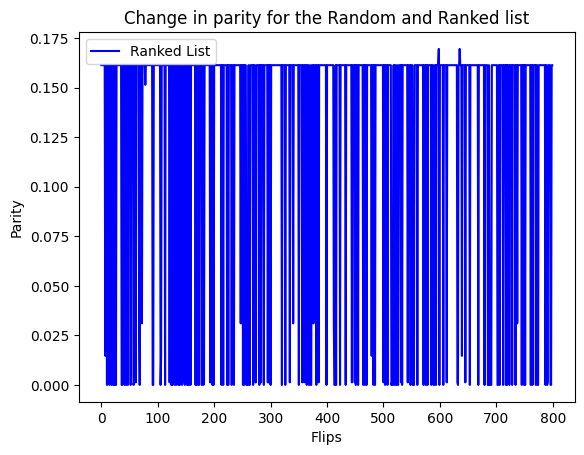

In [ ]:
#Plotting the random flips dataset and the systematic flips
#Systematic flips will have 800
#Random will have 150

#Plot the first dataset which is the ranked data list with 800 flips
#list_parity.sort(reverse=True)
x=range(len(list_parity))
plt.plot(x,list_parity,label='Ranked List',color='blue')

#Plot the second dataset which is the random list of 150 flips
x2 = range(len(random_list_parity))
#plt.plot(x2,random_list_parity,label='Random List',color='red')

#Entropy based flips
x3 = range(len(ranked_parity))
#plt.plot(x3,ranked_parity,label='Uncertainty Reduction',color='black')

#MEU based flips
x4 = range(len(MEU_ranked_parity))
#plt.plot(x4,MEU_ranked_parity,label='MEU',color='brown')

#Add the labels
plt.xlabel('Flips')
plt.ylabel('Parity')
plt.title('Change in parity for the Random and Ranked list')

#Add a legend
plt.legend()

#Show the plot
plt.show()

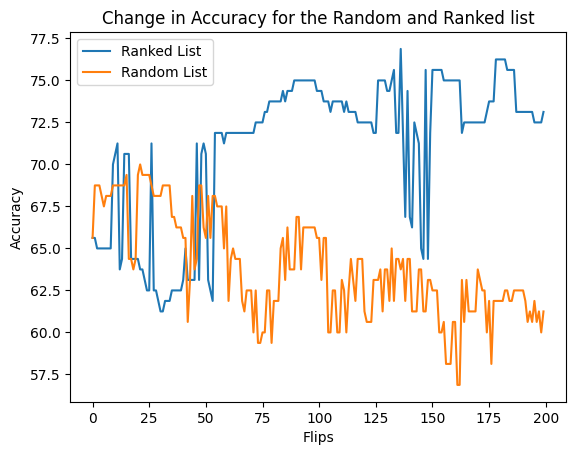

In [ ]:
#Plotting the random flips dataset and the systematic flips
#Systematic flips will have 800
#Random will have 150
#This is comparing the two accuracies

#Plot the first dataset which is the ranked data list with 800 flips
#list_parity.sort(reverse=True)
x=range(len(top_ranked_acc))
plt.plot(x,top_ranked_acc,label='Ranked List')

#Plot the second dataset which is the random list of 150 flips
x2 = range(len(random_list_acc))
plt.plot(x2,random_list_acc,label='Random List')

#Add the labels
plt.xlabel('Flips')
plt.ylabel('Accuracy')
plt.title('Change in Accuracy for the Random and Ranked list')

#Add a legend
plt.legend()

#Show the plot
plt.show()


In [ ]:
#Check to see which parity values are less than the original value based on the magnitude
similar_values_df = pd.DataFrame(columns=columns)
similar_values_encoded_data=pd.get_dummies(similar_values_df,columns=['checking_account_status','credit_history','savings_account_status','employment_status','personal_status','other_debtors','property','other_installment_plans','housing','job','telephone','foreign_worker','purpose'], drop_first=True)
for value in range(len(ranked_parity)):
    if abs(ranked_parity[value]) < abs(statistical_parity):
        row = train_full_df.iloc[ranked_flip[value]]
        similar_values_encoded_data = similar_values_encoded_data.append(row, ignore_index=True)

In [ ]:
#Get the original data from the german dataframe to see what the original labels are
check_labels = pd.DataFrame(columns=columns)
for value in range(len(ranked_parity)):
    if abs(ranked_parity[value]) < abs(statistical_parity):
        index = ranked_flip[value]
        check_labels = check_labels.append(german_df.loc[index])